In [1]:
import time, os, json
import numpy as np
from pandas import HDFStore, DataFrame
import tables
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array

from pong_rnn import PongRNN


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

Using Theano backend.
/usr/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [60]:
# load data 

q_list = []
p_list = []
y_list = []

with HDFStore('data.h5') as store: 
    for k in store.keys(): 
        d = np.array(store[k])[0:-1,:]
        
        assert d.shape == (100,1026)
        
        q = d[0:-1,0:1024].reshape((d.shape[0]-1, 32, 32))
        p = d[1:,1024:1026]
        y = d[1:,0:1024].reshape((d.shape[0]-1, 32, 32))
        
        assert ((q.shape[0] == p.shape[0]) and (q.shape[0] == y.shape[0]))
        assert q.shape == (99,32,32)
        assert p.shape == (99,2)
        assert y.shape == (99,32,32)
        
        q_list.append(q)
        p_list.append(p)
        y_list.append(y)

q_train = np.stack(q_list[0:-50])
p_train = np.stack((p_list[0:-50]))
y_train = np.stack(np.array(y_list[0:-50]))

q_val = np.stack(q_list[-50:])
p_val = np.stack(p_list[-50:])
y_val = np.stack(y_list[-50:])

#q_train = np.expand_dims(q_train, axis=2)

# q_train = np.concatenate(q_train)
# q_train = q_train.reshape((q_train.shape[0],1,q_train.shape[1],q_train.shape[2]))


print q_train.shape
print p_train.shape
print y_train.shape

print q_val.shape
print p_val.shape
print y_val.shape


(450, 99, 32, 32)
(450, 99, 2)
(450, 99, 32, 32)
(50, 99, 32, 32)
(50, 99, 2)
(50, 99, 32, 32)


In [95]:
y_train = y_train.reshape((-1,1024))
q_train = q_train.reshape((-1,1,32,32))
p_train = p_train.reshape((-1,2))

In [102]:
y_val = y_val.reshape((-1,1024))
q_val = q_val.reshape((-1,1,32,32))
p_val = p_val.reshape((-1,2))

In [150]:
# test run the model

model = PongRNN()
model.train(q_train, p_train, y_train, nb_epoch=1)

Epoch 1/1
44550/44550 [==============================] - 314s - loss: 0.0574   


In [201]:
y_pred = model.predict(q_val, p_val)

TypeError: predict() got an unexpected keyword argument 'accuracy'

In [118]:
print y_pred['screen_out'].shape
print np.mean(y_pred['screen_out']) * 255

(4950, 1024)
0.249023437372


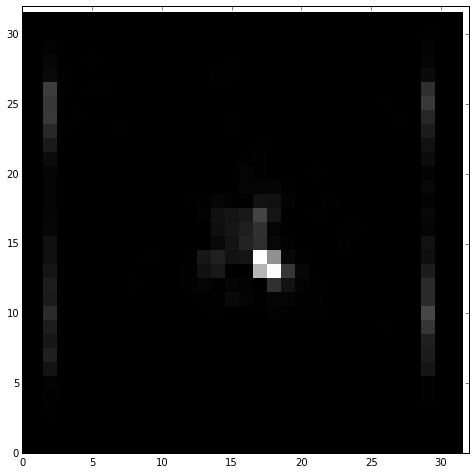

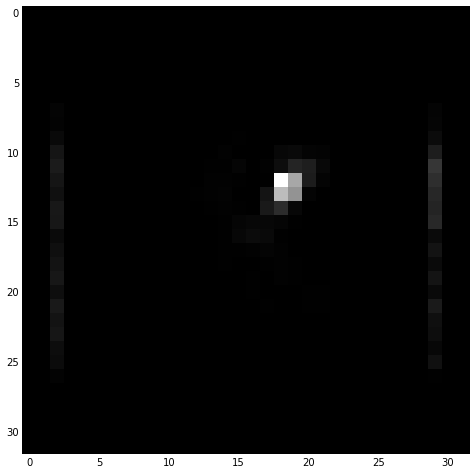

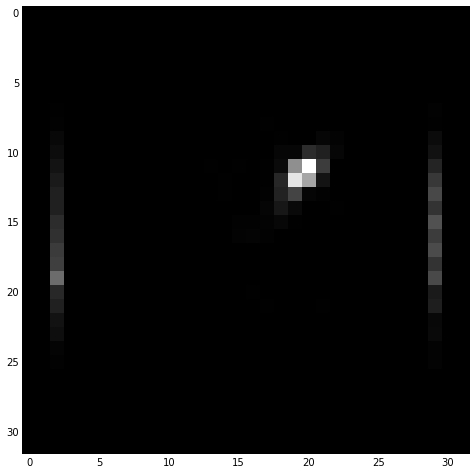

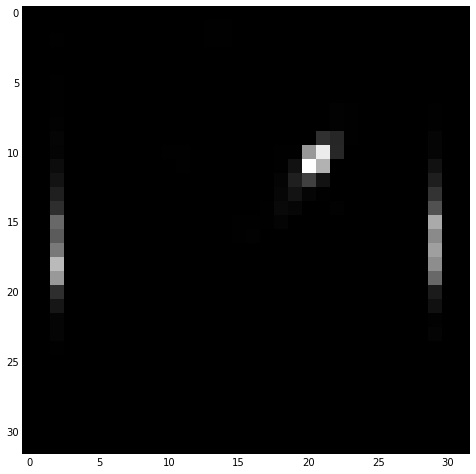

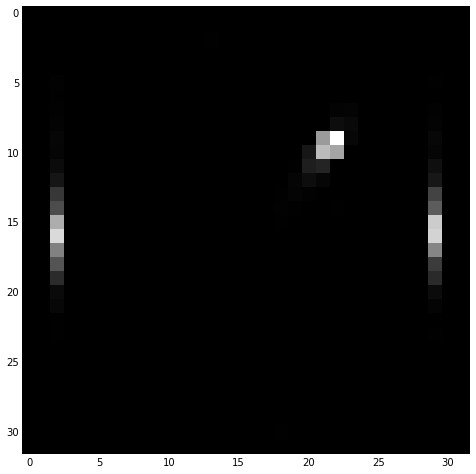

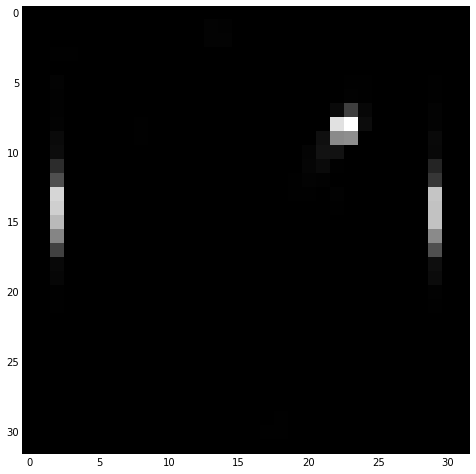

In [125]:
plt.axis([0,32,0,32])
plt.ion()

for row in y_pred['screen_out'][0:6,:]: 
    frame = row.reshape((32,32))
    #frame = np.where(frame > 0.1, 1, 0)
    plt.imshow(frame)
    plt.draw()
    plt.show()
    plt.pause(0.01)

In [124]:
# Visualize model predictions on validation set, save to gif

from PIL import Image, ImageSequence
from images2gif import writeGif

frames = []

for row in y_pred['screen_out'][0:300,:]: 
    frame = (row.reshape((32,32))*3060).astype(np.uint8)
    image = Image.fromarray(frame, mode='L')
    image = image.resize((256,256))
    frames.append(image)
    
 

writeGif("predicted-frames.gif", frames, duration=0.1)

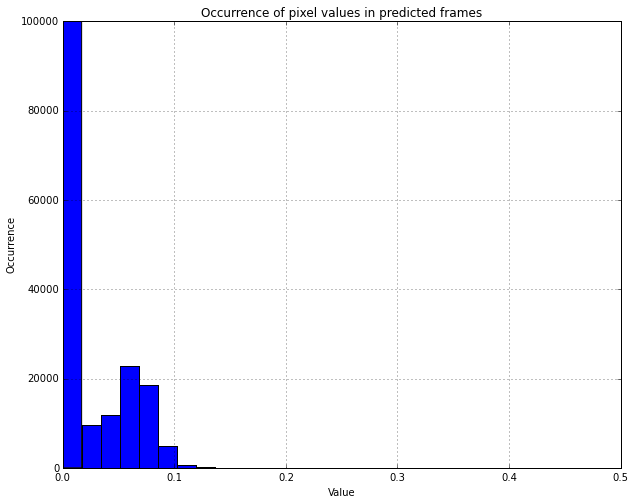

In [148]:
# visualize histogram of values in predicted frames

n, bins, patches = plt.hist(y_pred['screen_out'].flatten(), 10, facecolor='blue')
plt.xlabel('Value')
plt.ylabel('Occurrence')
plt.title(r'Occurrence of pixel values in predicted frames')
plt.axis([0, 0.5, 0, 100000])
plt.grid(True)

plt.show()


In [151]:
# overfit small data

[[[0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  ..., 
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]
  [0 0 0 ..., 0 0 0]]]


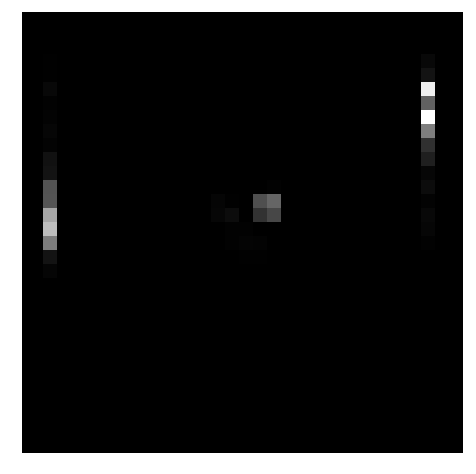

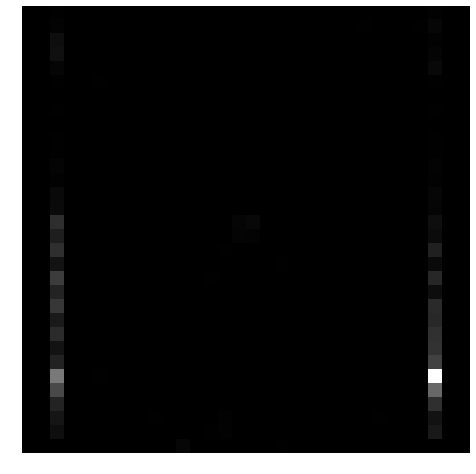

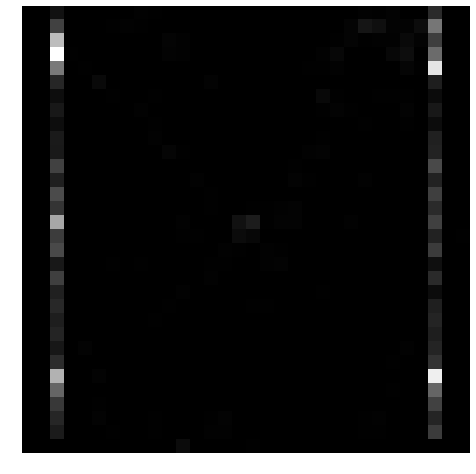

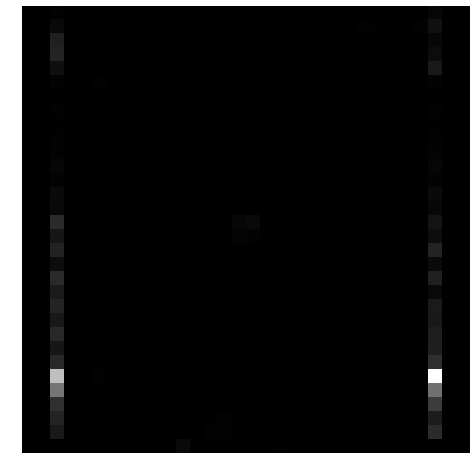

In [174]:
# Code for prediction with inputs -- 
#
# Results demonstrate that the model knows inputs control the paddles, although it doesn't know
# which inputs control which paddles (this is likely a data problem). 
#
# It also seems to grossly overestimate how fast the controls move the paddles, 
# and it either loses track of the ball or thinks the paddles move it or both. 

plt.axis([0,32,0,32])
plt.ion()

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

frames = []

i = 0
q = q_train[0]

input_possibilities = [
    np.array([1,1]),
    np.array([1,-1]),
    np.array([-1,-1]),
    np.array([-1,1]),
]

for p in input_possibilities: 
    p = np.array(p).reshape(1,2)
    q = q.reshape(1,1,32,32)
    q = model.predict(q,p,batch_size=1)['screen_out']
    imshow_noax(q.reshape((32,32)))
    plt.draw()
    plt.show()
    plt.pause(0.01)
    i += 1



(25, 32, 32, 1)


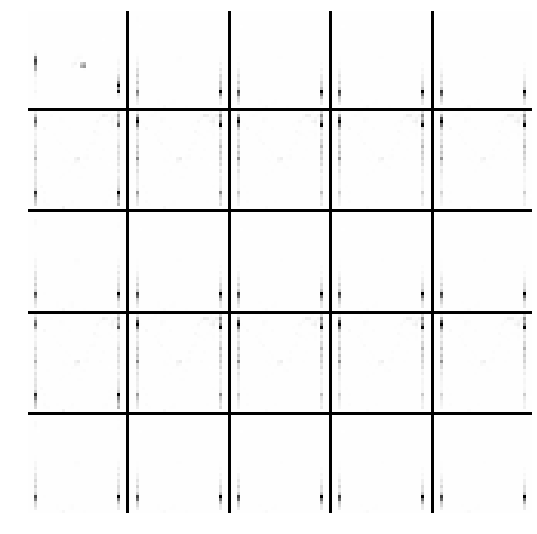

In [200]:

from cs231n.vis_utils import visualize_grid


frames = []

i = 0
q = q_train[0]
p = np.array([[1,1],[1,1],[1,1],[1,1],[1,1],[-1,-1],[-1,-1],[-1,-1],[-1,-1],[-1,-1]])
p = p.reshape((10,1,2))

while (i < 25): 
    q = q.reshape(1,1,32,32)
    q = model.predict(q,p[i % 10,:],batch_size=99)['screen_out']
    frames.append(-1*q.reshape(32,32,1))
    i += 1


frames = np.array(frames)
print frames.shape

grid = visualize_grid(frames)
grid = grid.reshape((grid.shape[0],-1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(9, 9)
plt.show()

In [203]:
model.graph.evaluate({'screen_in': q_val, 'control_in': p_val, 'screen_out': y_val})

0.037313299641163665